In this notebook, we consider the reparameterization trick. In the most general form, the "reparameterization trick" is concerned with computing stochastic gradients to solve the following problem
$$
min_\theta \mathbb{E}_{z\sim q_\theta(z)}\left[f(z,\theta, x)\right],
$$
where $x$ represents some fixed external variable (typically a datum from your dataset). Clearly, we can absorb $x$ into the definition of $f$, and will do so henceforth. Also, for the sake of presenting a simple example, we'll drop the dependence on $\theta$ in $f$. We'll focus on the following problem form
$$
min_\theta \underbrace{\mathbb{E}_{z~q_\theta(z)}\left[f(z)\right]}_{=: L(\theta)}.
$$

There are two ways I know of to compute an estimator of the gradient. The first is the likelihood ratio gradient (TODO: check why it's called that... https://arxiv.org/pdf/2105.14900.pdf), where you note that
$$
\nabla_\theta \log(q_\theta(z))f(z), \quad z\sim q_\theta(z)
$$
is an unbiased estimator of $\nabla L(\theta)$. The other is the reparameterization trick. Here, we find some function $g(z,\theta, \epsilon)$ and distribution $p(\epsilon)$ so that if $w = g(z, \theta, \epsilon)$ with $\epsilon\sim p(\epsilon)$, then the density of $w$ is identical to $q_\theta$. See other notes for more theoretical details. 

A major motivation for the reparameterization trick is that it provides a lower variance gradient estimator than the LR gradient. We explore that here with a toy example. 


**Toy Example:** Let $\theta \in \mathbb{R}^2$ be our parameter, let $x\in \mathbb{R}^2$ be some fixed value, and let
$$
L(\theta) = \mathbb{E}_{z\sim N(\theta, I)}\left[\|\theta - x \|^2 \right].
$$
This cost is minimized when $\theta = x$. 
One can confirm that the single-sample LR gradient estimator is given by 
$$
\hat{g}_{LR} = (z - \theta)\|z-x\|^2 \quad z\sim q_\theta(z)
$$
and that if we use the reparameterization $g(z, \theta, \epsilon) = \theta + \epsilon - x$ where $p(\epsilon) = N(0, I)$, then we get a valid reparameterization (the density of $g(z, \theta, \epsilon)$ is right) and we have 
$\mathbb{E}_{\epsilon \sim p(\epsilon)} \left[ \nabla_\theta g(\theta, \epsilon) \right] = \nabla_\theta L(\theta)$. The gradient estimator here is
$$
\hat{g}_{RP} = \theta + \epsilon - x, \quad \epsilon \sim N(0, I). 
$$

In the code below, we visualize using each of these gradient estimators for optimizing $L$. The variance of the LR gradient grows when it's farther from $x$. Make $x$ larger below to see interesting behavior in LR

In [5]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

alpha = .0001  # alpha = .0001 is a good value for running LR gradient and alpha = .01 is good for RP gradient

x = np.array((100, 100))
theta_0 = (0, 0)

theta_hat1 = np.array(theta_0)
theta_hat2 = np.array(theta_0)
theta1 = [theta_hat1]
theta2 = [theta_hat2]

T = 5000
for _ in range(T):
    z1 = np.random.randn(2) + theta_hat1
    eps = np.random.randn(2)

    g1 = (z1 - theta_hat1)*np.linalg.norm(z1 - x)**2
    g2 = theta_hat2 - x + eps

    theta_hat1 = theta_hat1 - alpha*g1
    theta_hat2 = theta_hat2 - alpha*g2

    theta1.append(theta_hat1.tolist())
    theta2.append(theta_hat2.tolist())



<IPython.core.display.Javascript object>


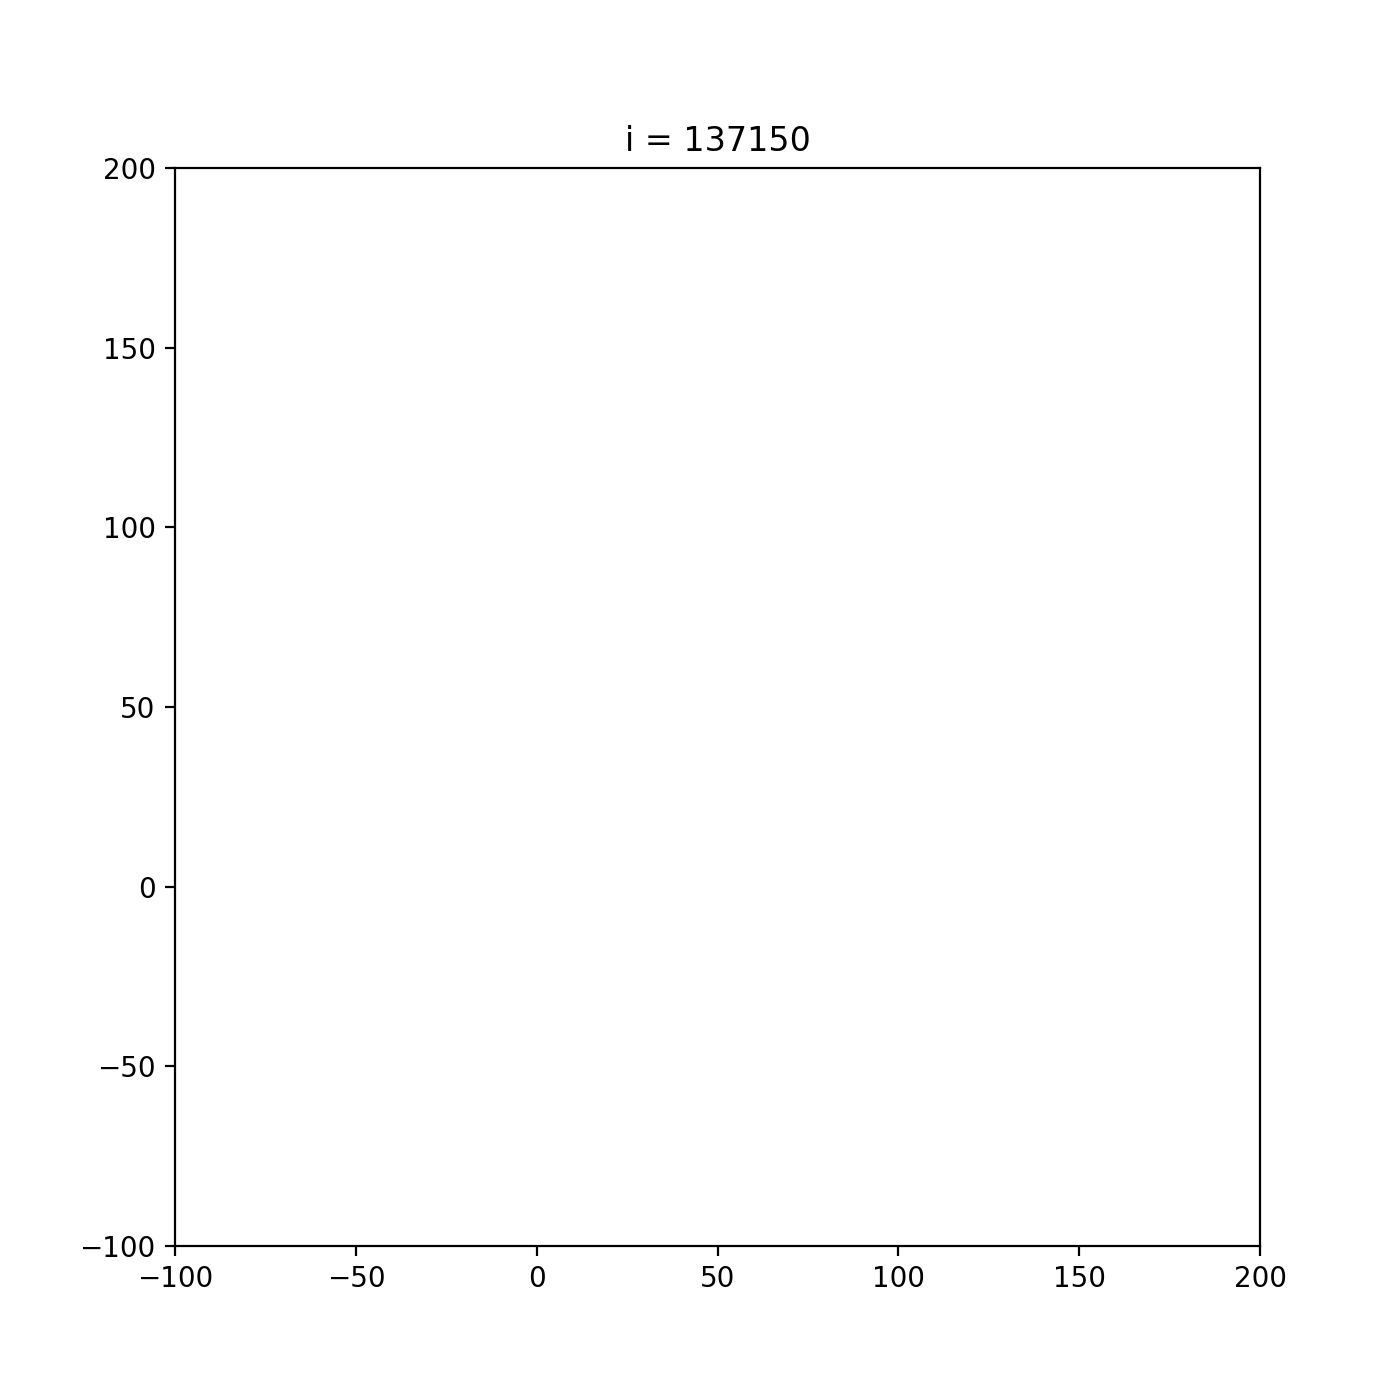

/var/folders/xb/4hhmcv5x1tx29d8pg1tqsjhc0000gn/T/ipykernel_37647/2840245026.py:15: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  anim = FuncAnimation(fig, update, interval=100)


In [7]:
# animate the process
theta = np.array(theta1)  # use this line to switch between LR (theta1) and RP (theta2) gradients
L = 5
n_plot_points = 50
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(xlim=(-theta_0[0]-100, x[0] + 100), ylim=(-theta_0[1]-100, x[1] + 100))
scatter=ax.scatter(theta[:n_plot_points, 0], theta[:n_plot_points, 1])

def update(i):
    k = 10
    scatter.set_offsets(theta[k*i:k*i+n_plot_points])
    plt.title(f'i = {k*i}')
    return scatter,

anim = FuncAnimation(fig, update, interval=100)
plt.show()

Final comments:
- The LR gradient becomes unreliable when you're far from $x$
- The RP gradient has consistently "low" variance. We've fixed the step size to be the same here. But you can make alpha much larger for the RP gradient and get faster convergence. 
- I need to write the code to actually terminate the animation at some point... 